Running

Opening usa
Model dimensions (mm): [1933. 1028.   10.]
New dimensions (mm): [10.          5.3181583   0.05173306]
Process terminated after "gcode/usa_0.00517331x_0.1.gcode" finished writing.                                                                                                                            

Saving usa_0.00517331x_0.1.png to plots


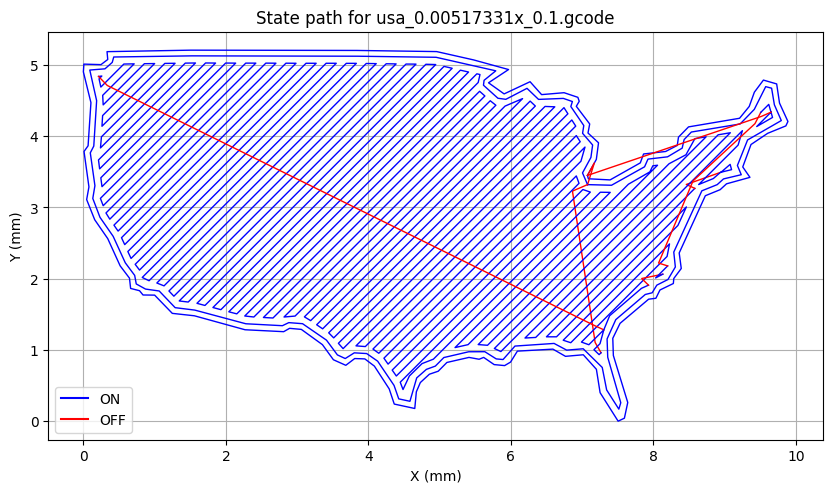

Saving usa_0.00517331x_0.1.txt to paths
Path generated for usa_0.00517331x

Exited


In [1]:
import sys
from PySide6 import QtWidgets
from PySide6 import QtCore
from PySide6 import QtGui
from PySide6.QtGui import *
from PySide6.QtWidgets import *
from PySide6.QtCore import *

import numpy as np
import pandas as pd
import pyqtgraph as pg
import cv2
from scipy.ndimage import gaussian_filter1d
import pyclipper
from shapely.geometry import Polygon, Point
import itertools
from scipy.signal import savgol_filter
import os

import ctypes
myappid = 'nil.laser.pyqt.2' # arbitrary string
ctypes.windll.shell32.SetCurrentProcessExplicitAppUserModelID(myappid)
import warnings
warnings.filterwarnings("ignore")

from importlib import reload
import ui.gui
reload(ui.gui)
from ui.gui import *

from path_generation import *

image_extensions = ["jpg", "jpeg", "png", "bmp", "gif", "tiff", "tif", "webp", "svg", "ico"]

def smoothContour(contour, sigma=2.0):
    """
    Smooths a contour using Gaussian filtering on x and y coordinates.
    
    :param contour: Input contour (Nx1x2)
    :param sigma: Gaussian standard deviation
    :return: Smoothed contour
    """
    if sigma != 0:
        contour = contour.squeeze()
        
        x_smooth = gaussian_filter1d(contour[:, 0], sigma=sigma, mode="wrap")
        y_smooth = gaussian_filter1d(contour[:, 1], sigma=sigma, mode="wrap")
    
        smoothed_contour = np.stack((x_smooth, y_smooth), axis=1).astype(np.int32)
        return smoothed_contour.reshape(-1, 1, 2)
    else:
        return contour

class MainWindow(QtWidgets.QMainWindow, Ui_MainWindow):
    def __init__(self):
        super(MainWindow, self).__init__()
        self.setupUi(self)
        self.setWindowTitle("Outliner")
        self.setWindowIcon(QtGui.QIcon('icon.png'))

        self.scatter = pg.ScatterPlotItem()
        self.image = None
        self.contour = self.outlinePlot.plot([1], [1], pen=pg.mkPen(color='green', width=2))
        self.data=None
        self.points=None
        self.fileName=None
        
        self.timer = QTimer()
        self.timer.timeout.connect(self.updateGraph)
        self.timer.start(33)

        self.actionSave.triggered.connect(self.saveFile)
        self.actionOpen.triggered.connect(self.openFile)
        self.generatePathButton.clicked.connect(self.generatePath)

    def updateGraph(self):
        if self.image is not None:
            image = self.image.copy()
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img_blur = cv2.GaussianBlur(image_gray,(3,3), sigmaX=0, sigmaY=0) 
            if self.actionAdaptive_Threshold.isChecked():
                thresh = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
            else:
                thresh = img_blur
            edges = cv2.Canny(image=thresh, threshold1=0, threshold2=255) 
            kernel = np.ones((5, 5), np.uint8)
            binary = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
            contours, hier = cv2.findContours(np.flip(np.rot90(binary), axis=0), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            largest_contour = max(contours, key=cv2.contourArea)
            
            image_items = [item for item in self.outlinePlot.getViewBox().allChildren() if isinstance(item, pg.ImageItem)]
            if self.actionHide_Image.isChecked():
                empty = np.zeros((1, 1), dtype=np.uint8)
                image_items[0].setImage(empty)
            else:
                if image_items and not self.actionShow_Original.isChecked():
                    image_items[0].setImage(binary)
                else:
                    image_items[0].setImage(self.image)

            epsilon = self.simplifySlider.value()/100000 * cv2.arcLength(largest_contour, True)
            simplified_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
            smoothed_contour = smoothContour(simplified_contour, self.smoothSlider.value()/50) 
            self.points = smoothed_contour.reshape((-1, 2))
            x, y = zip(*np.append(self.points, [self.points[0]],axis=0))
            x=np.array(x)
            y=np.array(y)
            
            self.contour.setData(x, y)

    def generatePath(self):
        cura_path = r"UltiMaker Cura 5.9.1"
        cura_engine_path = cura_path+r"\CuraEngine.exe"
        definitions_path = cura_path+r"\share\cura\resources\definitions"

        
        if self.points is None:
            msg = QMessageBox()
            msg.setWindowTitle("Error")
            msg.setText("No path to generate! Please select an image!!!")
            msg.setIcon(QMessageBox.Warning)
            msg.setStandardButtons(QMessageBox.Ok)
            msg.exec()
        else:
            size=self.diameter.value()/1000
            _, output_filename = generateSTL(self.points, self.fileName, self.largestDim.value())
            _ = generateJSON(size)
            os.makedirs("gcode", exist_ok=True)
            output_path = f"gcode/{output_filename}_{size}.gcode"
            stl_path = f"stl/{output_filename}.stl"
            machine_def_path = f"offsets/pather_{size}.def.json"
            coords, result, command, stderr, stdout = runCura(cura_engine_path, machine_def_path, definitions_path, stl_path, output_path, 5, plot=True)
            print(f"Path generated for {output_filename}")
            
    def openFile(self):
        options = QFileDialog.Options()
        files, _ = QFileDialog.getOpenFileNames(self, "Open Files", "", "Image Files (*.jpg;*.jpeg;*.png;*.bmp;*.gif;*.tiff;*.tif;*.webp;*.svg;*.ico)", options=options)
        if files:
            for file in files:
                self.parseFiles(file)
                break

    def saveFile(self):
        if self.data is None:
            msg = QMessageBox()
            msg.setWindowTitle("Error")
            msg.setText("No data to save! Please select an image!!!")
            msg.setIcon(QMessageBox.Warning)
            msg.setStandardButtons(QMessageBox.Ok)
            msg.exec()
        else:
            options = QFileDialog.Options()
            fileName, _ = QFileDialog.getSaveFileName(self,
                                                      "Save CSV/Excel File",
                                                      "",
                                                      "CSV Files (*.csv);;Excel Files (*.xlsx)",
                                                      options=options)
            
            if fileName:
                data = pd.DataFrame(self.data, index=True)
                data.to_csv(filename)
                print(f"File saved as: {fileName}")
    
    def parseFiles(self, file):
        accepted = False
        fileType = file.split(".")[-1] # return file extension
        for imageType in image_extensions:
            if fileType == imageType:
                accepted = True # return true if file is a video
                break
        if not accepted:
            msg = f'File type: ".{fileType}" not accepted. \nAllowed file types:  ".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".tif", ".webp", ".svg", ".ico"\n'
            print(msg) 
            return
        else:
            msg = f'File opened: {file}'
            self.fileName = os.path.splitext(file)[0]
            self.fileName = os.path.basename(self.fileName)
            try:
                print(f'Opening {self.fileName}')
                image_path = file
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                self.image = np.rot90(np.array(image))
                self.outlinePlot.clear()
                self.outlinePlot.getViewBox().invertY(True)
                self.outlinePlot.getViewBox().invertX(True)
                self.outlinePlot.addItem(pg.ImageItem(self.image))
                self.outlinePlot.getViewBox().setAspectLocked(True)
                self.outlinePlot.addItem(self.contour)
            except Exception as e:
                msg = f'Failed to open file: {file} {e}'
                print(msg)   
    
    def dragEnterEvent(self, event):
        if event.mimeData().hasUrls(): # check if dragged item has file location/url
            event.accept()
        else:
            event.ignore()

    def dropEvent(self, event):
        if event.mimeData().hasUrls():
            Qfiles = event.mimeData().urls()
            files = [Qfile.toLocalFile() for Qfile in Qfiles] # convert qt-type to file path string
            for file in files:
                self.parseFiles(file)
                break
            event.accept()
        else:
            event.ignore()
    
    def closeEvent(self, event):
        try:
            event.accept()
            super().closeEvent(event)
        except Exception as e:
            print(f"Error during close event: {e}")
            event.ignore()
        print('\nExited')

if not QtWidgets.QApplication.instance():
    app = QtWidgets.QApplication(sys.argv)
else:
    app = QtWidgets.QApplication.instance()

if __name__ == '__main__':
    window = MainWindow()
    app.setStyle('Windows')
    window.show()
    print('Running\n')
    app.exec()